In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from prophet import Prophet

In [2]:
# Load dataset
file_path = "/content/drive/MyDrive/SE_ML.csv"  # Update if needed
data = pd.read_csv(file_path)


In [3]:
import pandas as pd

# Load the dataset
file_path = "/content/drive/MyDrive/SE_ML.csv"  # Update with the correct path if needed
data = pd.read_csv(file_path)

# Fix Date Column
try:
    # Attempt to parse the date with the correct format
    data['Date'] = pd.to_datetime(data['Date'], format="%d-%m-%Y %H:%M", errors='coerce')
except:
    # If the above fails, try with dayfirst=True (common for non-US formats)
    data['Date'] = pd.to_datetime(data['Date'], dayfirst=True, errors='coerce')

# Check for missing values after parsing
missing_dates = data['Date'].isna().sum()
if missing_dates > 0:
    print(f"⚠ Warning: {missing_dates} rows have invalid dates and will be removed.")

# Drop rows with invalid dates
data.dropna(subset=['Date'], inplace=True)

# Set Date as index
data.set_index('Date', inplace=True)

# Display a sample to verify
print("✅ Date column successfully converted and set as index.")
print(data.head())



✅ Date column successfully converted and set as index.
                     Temperature  Dew Point  DHI  GHI  DNI  Wind Speed
Date                                                                  
1998-01-01 00:30:00          9.4        1.0    0    0    0         2.1
1998-01-01 01:30:00          8.9        0.9    0    0    0         2.3
1998-01-01 02:30:00          8.4        0.8    0    0    0         2.4
1998-01-01 03:30:00          8.0        0.8    0    0    0         2.5
1998-01-01 04:30:00          7.7        0.7    0    0    0         2.4


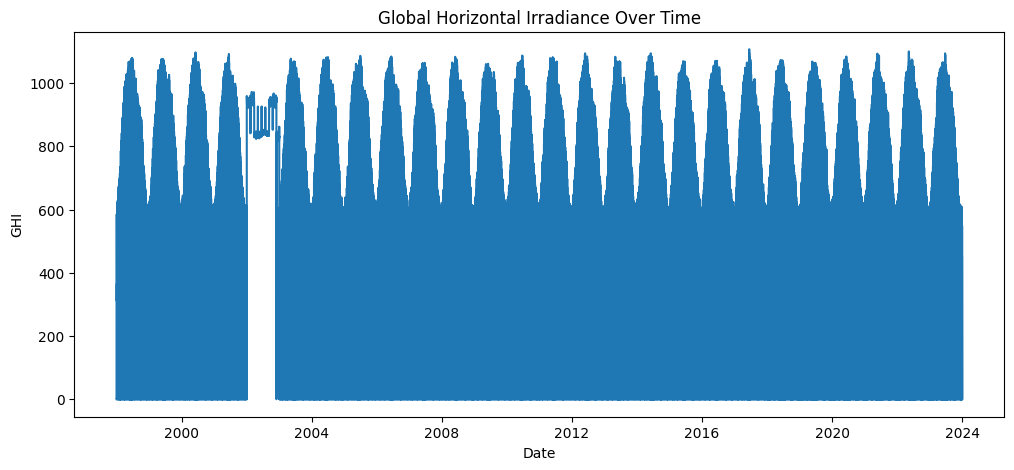

In [4]:
# Exploratory Data Analysis
plt.figure(figsize=(12, 5))
sns.lineplot(data=data, x=data.index, y='GHI')
plt.title("Global Horizontal Irradiance Over Time")
plt.show()

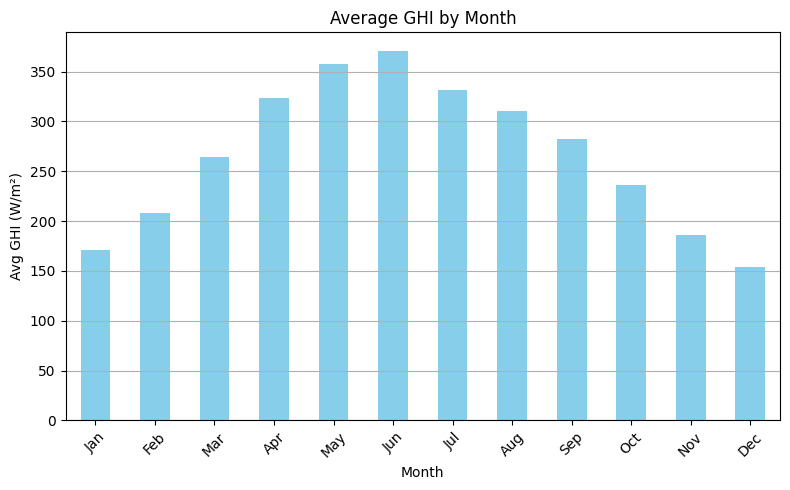

In [12]:
monthly_avg = data.groupby(data.index.month)['GHI'].mean()

plt.figure(figsize=(8,5))
monthly_avg.plot(kind='bar', color='skyblue')
plt.title('Average GHI by Month')
plt.xlabel('Month')
plt.ylabel('Avg GHI (W/m²)')
plt.xticks(ticks=range(0,12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                                      'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


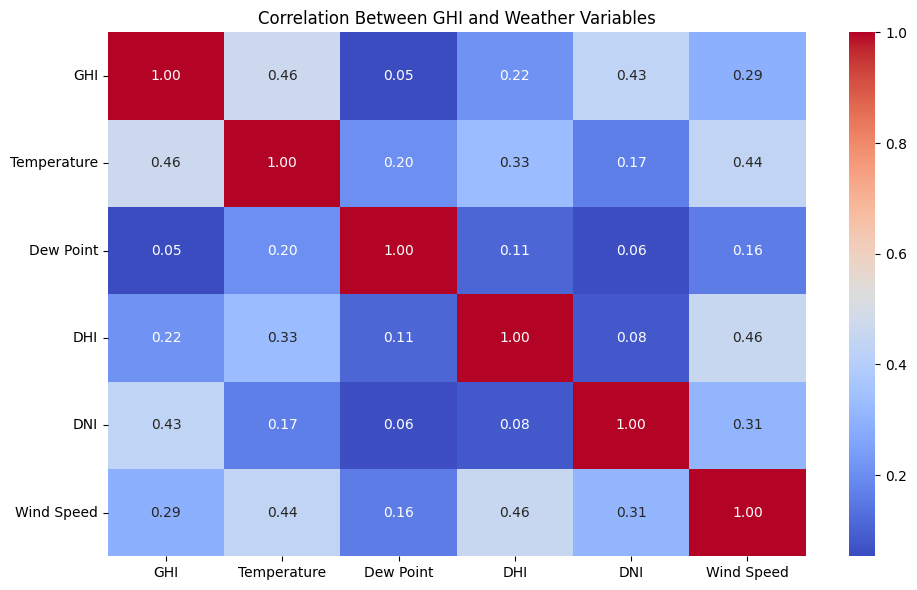

In [13]:
import seaborn as sns

plt.figure(figsize=(10,6))
sns.heatmap(data[['GHI', 'Temperature', 'Dew Point', 'DHI', 'DNI', 'Wind Speed']].corr(),
            annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Between GHI and Weather Variables')
plt.tight_layout()
plt.show()


In [5]:
# Feature Engineering
data['Year'] = data.index.year
data['Month'] = data.index.month
data['Day'] = data.index.day
data['DayOfWeek'] = data.index.dayofweek
data['DayOfYear'] = data.index.dayofyear
data['Sin_DayOfYear'] = np.sin(2 * np.pi * data['DayOfYear'] / 365.0)
data['Cos_DayOfYear'] = np.cos(2 * np.pi * data['DayOfYear'] / 365.0)
data['Lag_1'] = data['GHI'].shift(1)
data['Lag_7'] = data['GHI'].shift(7)
data.dropna(inplace=True)

In [6]:
# Split data into train and test
train_data = data[:'2020-12-31']
test_data = data['2021-01-01':]
feature_cols = ['Year','Month','Day','DayOfWeek','Sin_DayOfYear','Cos_DayOfYear','Lag_1','Lag_7']
scaler = MinMaxScaler()
train_data[feature_cols] = scaler.fit_transform(train_data[feature_cols])
test_data[feature_cols] = scaler.transform(test_data[feature_cols])

X_train = train_data[feature_cols]
y_train = train_data['GHI']
X_test = test_data[feature_cols]
y_test = test_data['GHI']
print("Training set size:", X_train.shape, "Test set size:", X_test.shape)

Training set size: (201617, 8) Test set size: (26280, 8)


<ipython-input-6-05e264f79927>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data[feature_cols] = scaler.fit_transform(train_data[feature_cols])
<ipython-input-6-05e264f79927>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data[feature_cols] = scaler.transform(test_data[feature_cols])


In [7]:
# XGBoost Model
xgb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)
print("XGBoost RMSE:", rmse_xgb, "R² Score:", r2_xgb)

XGBoost RMSE: 46.661478592124354 R² Score: 0.9791457046213994


In [19]:
# LSTM Model
X_train_lstm = np.reshape(X_train.values, (X_train.shape[0], X_train.shape[1], 1))
X_test_lstm = np.reshape(X_test.values, (X_test.shape[0], X_test.shape[1], 1))
lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train_lstm.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train_lstm, y_train, epochs=20, batch_size=32, verbose=1)
y_pred_lstm = lstm_model.predict(X_test_lstm).flatten()
rmse_lstm = np.sqrt(mean_squared_error(y_test, y_pred_lstm))
r2_lstm = r2_score(y_test, y_pred_lstm)
print("LSTM RMSE:", rmse_lstm, "R² Score:", r2_lstm)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6301/6301 ━━━━━━━━━━━━━━━━━━━━ 33s 5ms/step - loss: 159126.4844
Epoch 2/20
6301/6301 ━━━━━━━━━━━━━━━━━━━━ 41s 5ms/step - loss: 118885.0938
Epoch 3/20
6301/6301 ━━━━━━━━━━━━━━━━━━━━ 41s 5ms/step - loss: 118742.7656
Epoch 4/20
6301/6301 ━━━━━━━━━━━━━━━━━━━━ 42s 5ms/step - loss: 117461.3047
Epoch 5/20
6301/6301 ━━━━━━━━━━━━━━━━━━━━ 40s 5ms/step - loss: 54166.8906
Epoch 6/20
6301/6301 ━━━━━━━━━━━━━━━━━━━━ 42s 5ms/step - loss: 18083.7324
Epoch 7/20
6301/6301 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - loss: 8107.4976
Epoch 8/20
6301/6301 ━━━━━━━━━━━━━━━━━━━━ 32s 5ms/step - loss: 6658.6426
Epoch 9/20
6301/6301 ━━━━━━━━━━━━━━━━━━━━ 42s 5ms/step - loss: 6202.7197
Epoch 10/20
6301/6301 ━━━━━━━━━━━━━━━━━━━━ 39s 5ms/step - loss: 5987.4399
Epoch 11/20
6301/6301 ━━━━━━━━━━━━━━━━━━━━ 41s 5ms/step - loss: 5750.5386
Epoch 12/20
6301/6301 ━━━━━━━━━━━━━━━━━━━━ 43s 5ms/step - loss: 5515.2549
Epoch 13/20
6301/6301 ━━━━━━━━━━━━━━━━━━━━ 36s 6ms/step - loss: 5310.3188
Epoch 14/20
6301/6301 ━━━━━━━━━━━━━━━━━━━━ 31s 5

In [15]:
# Prophet Model
df_prophet = data[['GHI']].reset_index().rename(columns={'Date': 'ds', 'GHI': 'y'})
prophet = Prophet()
prophet.fit(df_prophet)
future = prophet.make_future_dataframe(periods=365, freq='D')
forecast = prophet.predict(future)
plt.show()

DEBUG:cmdstanpy:input tempfile: /tmp/tmp757p2bnx/h1nnmgs8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp757p2bnx/80bafxpz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63213', 'data', 'file=/tmp/tmp757p2bnx/h1nnmgs8.json', 'init=/tmp/tmp757p2bnx/80bafxpz.json', 'output', 'file=/tmp/tmp757p2bnx/prophet_modelkzd21kn_/prophet_model-20250406223043.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:30:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:33:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


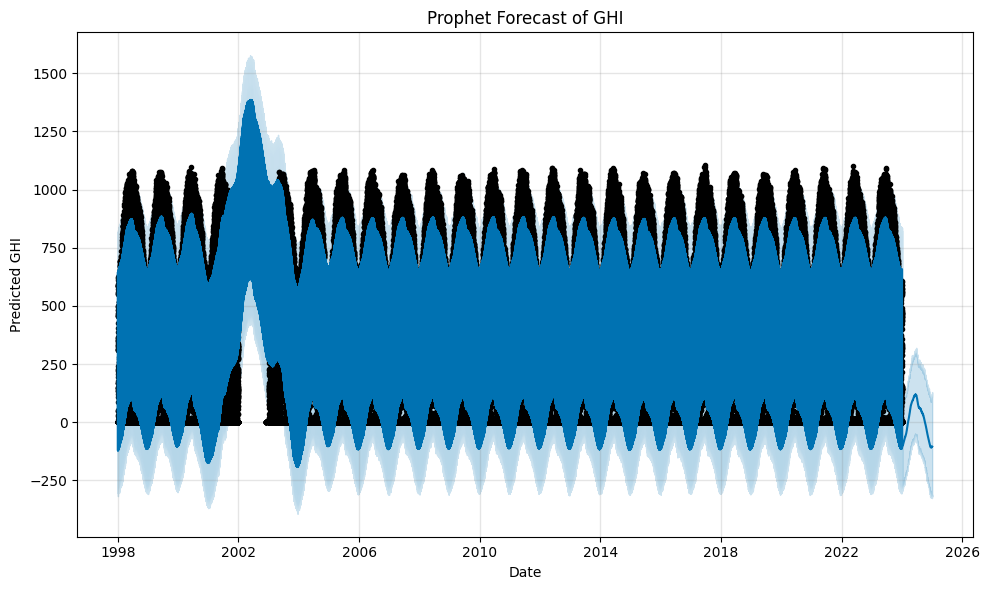

In [14]:
prophet.plot(forecast)
plt.title("Prophet Forecast of GHI")
plt.xlabel("Date")
plt.ylabel("Predicted GHI")
plt.tight_layout()
plt.show()


In [10]:
# Comparing Results
results = pd.DataFrame({
    "Model": ["XGBoost", "LSTM"],
    "RMSE": [rmse_xgb, rmse_lstm],
    "R² Score": [r2_xgb, r2_lstm]
})
print(results)


     Model       RMSE  R² Score
0  XGBoost  46.661479  0.979146
1     LSTM  54.071949  0.971996


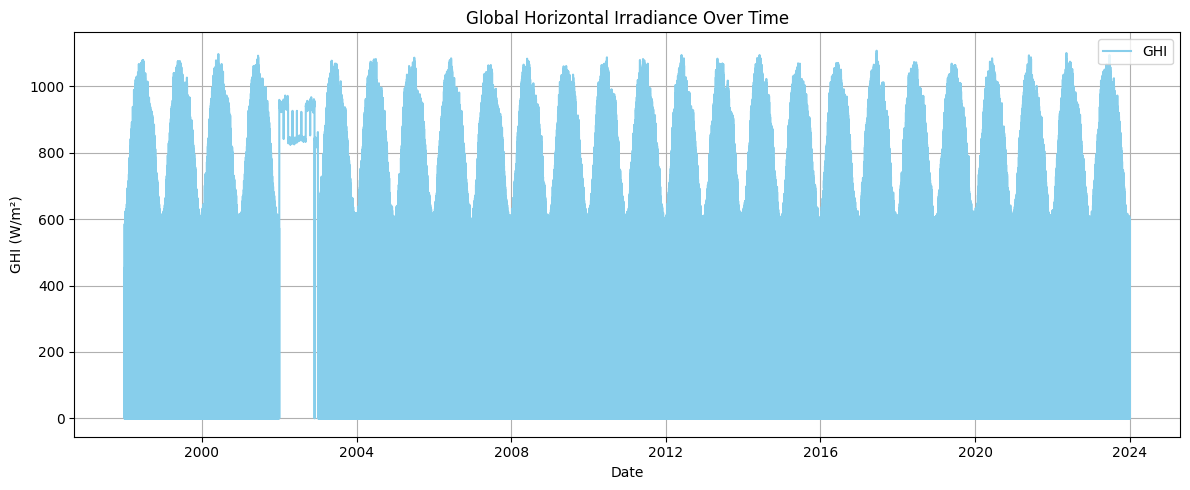

In [17]:
plt.figure(figsize=(12,5))
plt.plot(data.index, data['GHI'], label='GHI', color='skyblue')
plt.title('Global Horizontal Irradiance Over Time')
plt.xlabel('Date')
plt.ylabel('GHI (W/m²)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
